In [1]:
from pygeotemporal.sensors import SensorsApi
from pygeotemporal.streams import StreamsApi
from pygeotemporal.datapoints import DatapointsApi

from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd

# host = r"http://localhost:9000"
host = r"https://gltg-dev.ncsa.illinois.edu/geostreams"
username = "" 
password = "" # password for instance

sensorclient = SensorsApi(host=host, username=username, password=password)
streamclient = StreamsApi(host=host, username=username, password=password)
datapointclient = DatapointsApi(host=host, username=username, password=password)

from pprint import pprint

In [2]:
since = '20060901' # Date to start getting datapoints
until = '20200910' # Date to end getting datapoints
sources = None
format_out = "json" # Don't change unless you plan to change methods
only_count = "false" # set to "true" to get number of datapoints without pulling datapoints

coordinates = [
                [
                    -87.614822,
                    36.3239771
                ],
                [
                    -87.5488661,
                    35.7375952
                ],
                [
                    -85.8120269,
                    35.8178132
                ],
                [
                    -85.9549314,
                    36.3947567
                ],
                [
                    -87.614822,
                    36.3239771
                ]
            ]
  


In [3]:
def create_geocode():
    
    geocode = ''    
    for coord in coordinates:
        geocode += str(round(coord[1],8)) + '%2C' + str(round(coord[0],8)) + '%2C'
    geocode = geocode[:-3]
    
    return geocode

def get_sensors_by_geocode(geocode):
    r = sensorclient.sensors_by_polygon(geocode)
    
    if r.status_code != 200:
        print("Failed to get sensors with status code %s" % r.status_code)
        
    sensors = r.json()['sensors']
    
    print("Downloaded %s sensors" % len(sensors))
    
    return sensors

def get_sensors_parameters(sensors):
    sensors_parameters = []
    for sensor in sensors:
        for param in sensor['parameters']:
            if param in sensors_parameters or param in ['owner','site','source']:
                continue
            sensors_parameters.append(param)
        break
    
    return sensors_parameters

def create_sensor_dataframe(sensors):
    
    sensor_rows = []
    for sensor in sensors:
        row = []
        row.append(sensor['id'])
        row.append(sensor['name'])
        if 'type' in sensor['properties'] and 'network' in sensor['properties']['type']:
            row.append(sensor['properties']['type']['network'])
        else:
            row.append('')
        row.append(sensor['min_start_time'])
        row.append(sensor['max_end_time'])
        row.append(sensor['geometry']['coordinates'][1])
        row.append(sensor['geometry']['coordinates'][0])
        if 'huc_name' in sensor['properties']['huc']:
            row.append(sensor['properties']['huc']['huc_name'])
        else:
            row.append('')
        row.append(sensor['properties']['huc']['huc8']['code'])
        
        sensor_rows.append(row)

    sensors_dataframe = pd.DataFrame(sensor_rows,columns=['SENSOR_ID',
                                                            'NAME',
                                                            'NETWORK',
                                                            'DATA_START',
                                                            'DATA_END',
                                                            'LATITUDE',
                                                            'LONGITUDE',
                                                            'HUC NAME',
                                                            'HUC8'])       
    return sensors_dataframe

def get_datapoints(sensors):
    
    all_datapoints = []

    for sensor in sensors:
        r = datapointclient.get_datapoints(
                                            sensor_id=sensor['id'], 
                                            since=since, 
                                            until=until, 
                                            sources=sources, 
                                            format=format_out, 
                                            onlyCount=only_count
        )

        if r.status_code != 200:
            print("Datapoints download for sensor %s failed with status code %s" % (sensor_id, r.status_code))
            continue
        
        all_datapoints += r.json()
        
    return all_datapoints

def create_datapoints_dataframe(datapoints, sensors_parameters):
    
    column_names = ['sensor_id','datetime','created'] + sensors_parameters
#     print(len(column_names))
#     print(column_names)
    datapoint_rows = []
    for datapoint in datapoints:
        row = []
        row.append(datapoint['sensor_id'])
        row.append(datetime.strptime(datapoint['start_time'][:-4].replace('"T"','T'),'%Y-%m-%dT%H:%M'))
        row.append(datetime.strptime(datapoint['created'][:-4].replace('"T"','T'),'%Y-%m-%dT%H:%M'))
    
    
        for prop in sensors_parameters:
            if prop == "site":
                continue
            if prop in datapoint['properties']:
                row.append(datapoint['properties'][prop])
            else:
                row.append('')
        datapoint_rows.append(row)
#         print(len(row))
#         print(row)
        
    datapoint_dataframe = pd.DataFrame(datapoint_rows, columns=column_names)
    for param in column_names[3:]:
        datapoint_dataframe[param] = pd.to_numeric(datapoint_dataframe[param])
        
    return datapoint_dataframe
    

In [4]:
geocode = create_geocode()

sensors = get_sensors_by_geocode(geocode)

sensors_parameters = get_sensors_parameters(sensors)

sensor_dataframe = create_sensor_dataframe(sensors)

datapoints = get_datapoints(sensors)

datapoints_dataframe = create_datapoints_dataframe(datapoints, sensors_parameters)



Downloaded 32 sensors


In [5]:
sensor_dataframe.head(3)
sensor_dataframe.tail(3)

datapoints_dataframe.head(3)
datapoints_dataframe.tail(3)

datapoints_dataframe[sensors_parameters].describe()



,ammonia-mgl,conductivity-umhocm,dissolved-oxygen-mgl,e-coli-mpndl,fecal-coliforms-mpndl,nitrate-nitrite-as-n-mgl,nitrogen-kjeldahl-total-as-n-mgl,ph,temperature-c,total-organic-carbon-mgl,total-phosphorus-mgl
count,343.000000,681.000000,659.000000,613.000000,410.000000,569.000000,495.000000,682.000000,683.000000,317.000000,561.000000
mean,0.059758,403.673979,9.766449,340.179445,679.741463,0.676309,0.262727,7.891202,16.696193,2.145426,0.216832
std,0.351649,134.208157,2.407055,1143.333855,4106.864429,0.604901,0.366784,0.344818,9.882686,0.994202,0.987178
min,0.028000,3.770000,3.020000,1.000000,1.000000,0.006000,0.130000,6.330000,2.310000,0.100000,0.002000
25%,0.030000,286.000000,8.105000,38.000000,38.250000,0.240000,0.140000,7.700000,11.430000,1.500000,0.029000
50%,0.030000,411.000000,9.560000,107.000000,120.000000,0.490000,0.150000,7.925000,16.540000,2.000000,0.100000
75%,0.033000,506.000000,11.420000,300.000000,360.000000,1.000000,0.300000,8.100000,21.595000,2.600000,0.270000
max,6.500000,830.000000,22.310000,24200.000000,60000.000000,4.700000,7.000000,9.250000,217.830000,7.500000,23.000000


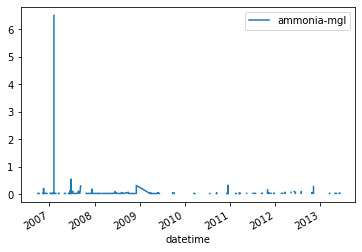

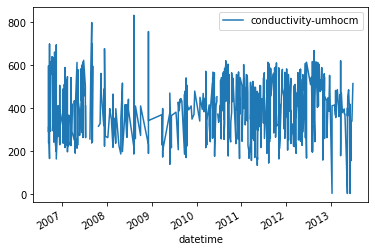

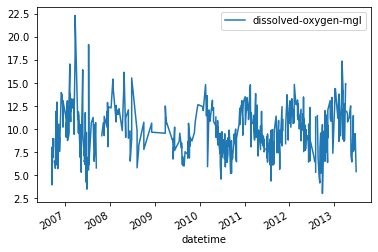

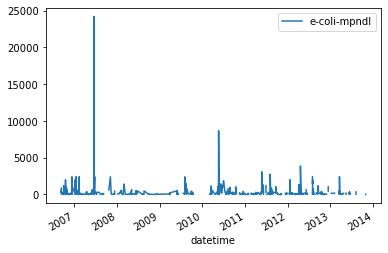

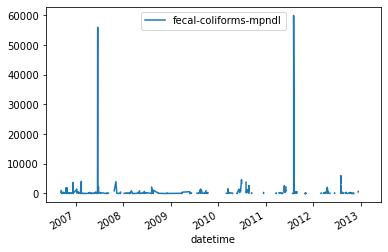

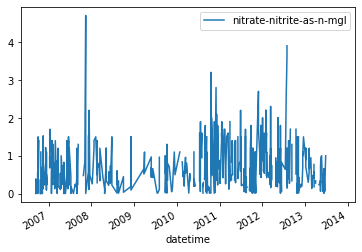

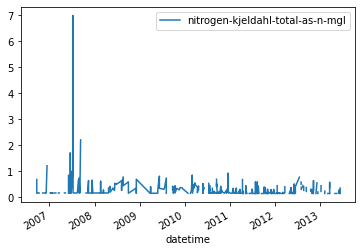

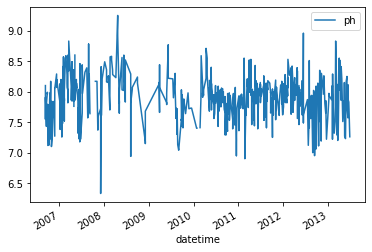

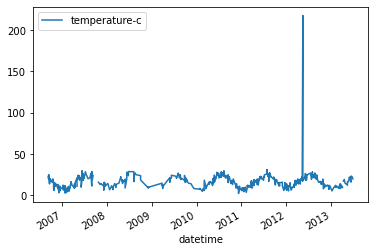

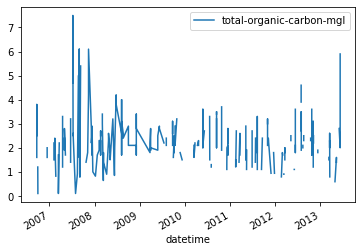

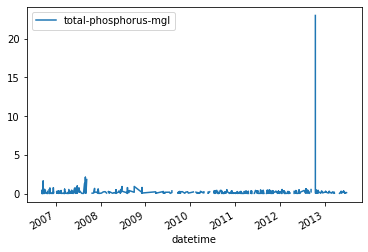

In [6]:
for param in sensors_parameters:
    datapoints_dataframe.plot(kind='line',x='datetime',y=param)